# Regularized FEVD estimation
## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno

import networkx as nx
import datetime as dt

#from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

import sys
sys.path.append('../')

import src
#from src.net import ElasticNet # glmnet estimator
#from src.var import FAVAR

/home/rubelrennfix/.virtualenvs/euraculus/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
sys.path.append('../../kungfu/')
import kungfu as kf

## Full estimation

In [110]:
var_grid = {'alpha': [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1],
            'lambdau': np.geomspace(1e-5, 1e-0, 15),
           } # for logged data

cov_grid = {'confidence_level': np.append(np.linspace(0.5, 0.95, 10), np.array([1-1e-4])),
            'eta': np.linspace(0, 2, 13)
           }

horizon = 20

In [111]:
desc_all = pd.DataFrame()
network_data_all = pd.DataFrame()

In [ ]:
for year in range(2019, 2020):#(1994, 2020):
    preprocessed_data, var_cv, var, cov_cv, cov, fevd, desc, network_data = src.estimate.run_estimation(year, var_grid, cov_grid, horizon)
    
    # append data
    desc_all = desc_all.append(desc.rename(year).to_frame().T)
    network_data.index = pd.MultiIndex.from_product([[year],network_data.index], names=['sampling_year', 'permno'])
    network_data_all = network_data_all.append(network_data)

    print('DONE WITH {}'.format(year))
    
    #desc_all.to_csv('../data/estimated/estimation_statistics_2.csv')
    #network_data_all.to_csv('../data/estimated/network_data_2.csv')

Fitting 12 folds for each of 195 candidates, totalling 2340 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min


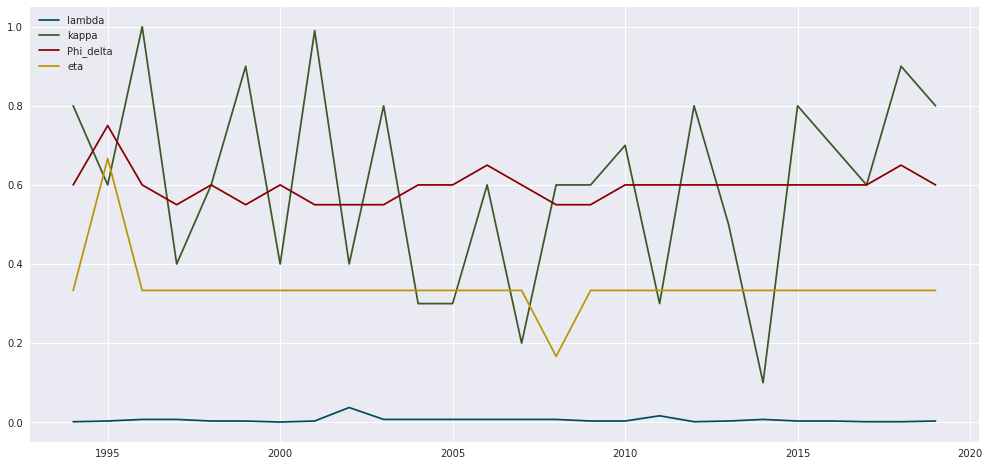

In [7]:
desc_all[['lambda', 'kappa', 'Phi_delta', 'eta']].plot()

In [8]:
desc_all[['lambda', 'kappa', 'Phi_delta', 'eta']].mean()

lambda       0.006008
kappa        0.603462
Phi_delta    0.596154
eta          0.339744
dtype: float64

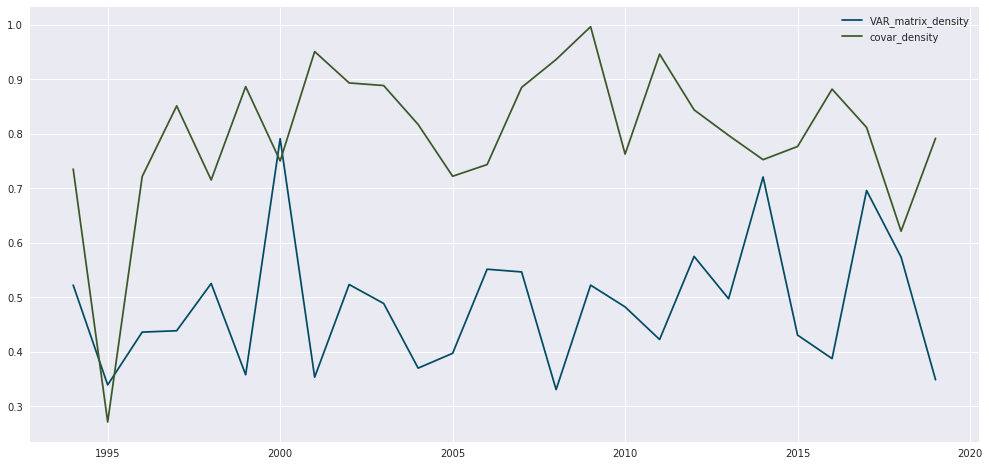

In [9]:
desc_all[['VAR_matrix_density', 'covar_density']].plot()

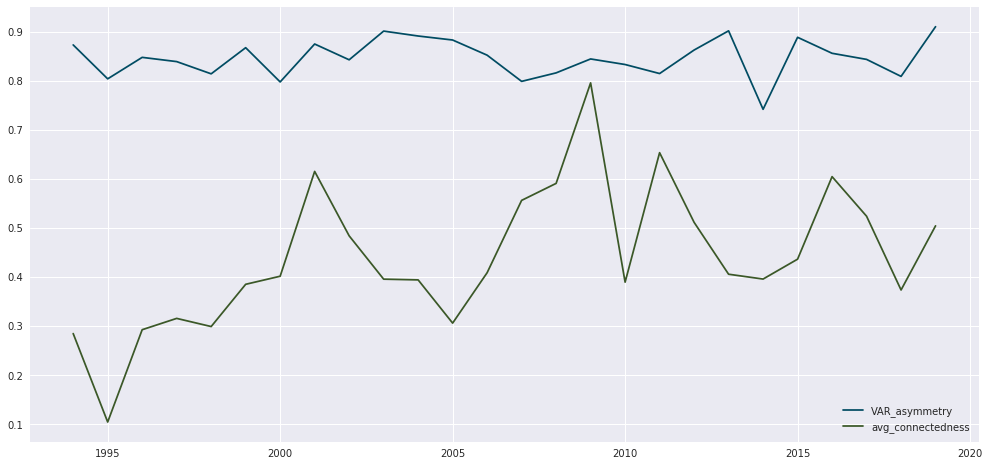

In [10]:
desc_all[['VAR_asymmetry', 'avg_connectedness']].plot()

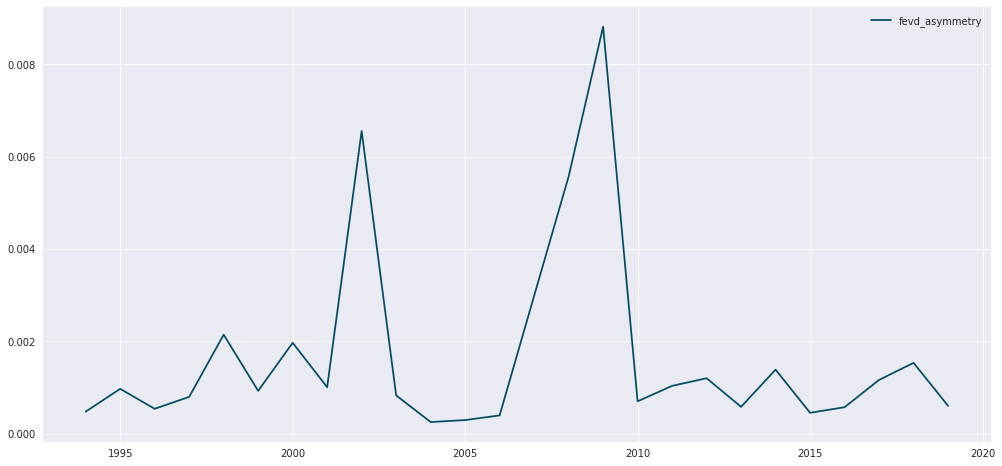

In [11]:
desc_all[['fevd_asymmetry']].plot()

## Single year analysis
### Load data

In [6]:
year = 2019

In [7]:
df_returns = src.loader.load_year(year, data='returns')
df_volas = src.loader.load_year(year, data='volas')
df_idio_vola = src.loader.load_year(year, data='idio_vola')**2
df_idio_var = src.loader.load_year(year, data='idio_var')
# df_idio_vola = src.loader.load_year(year, data='ff3_residuals')**2
df_spy_vola = src.loader.load_spy_vola(year)
tickers = src.loader.load_year_tickers(year)

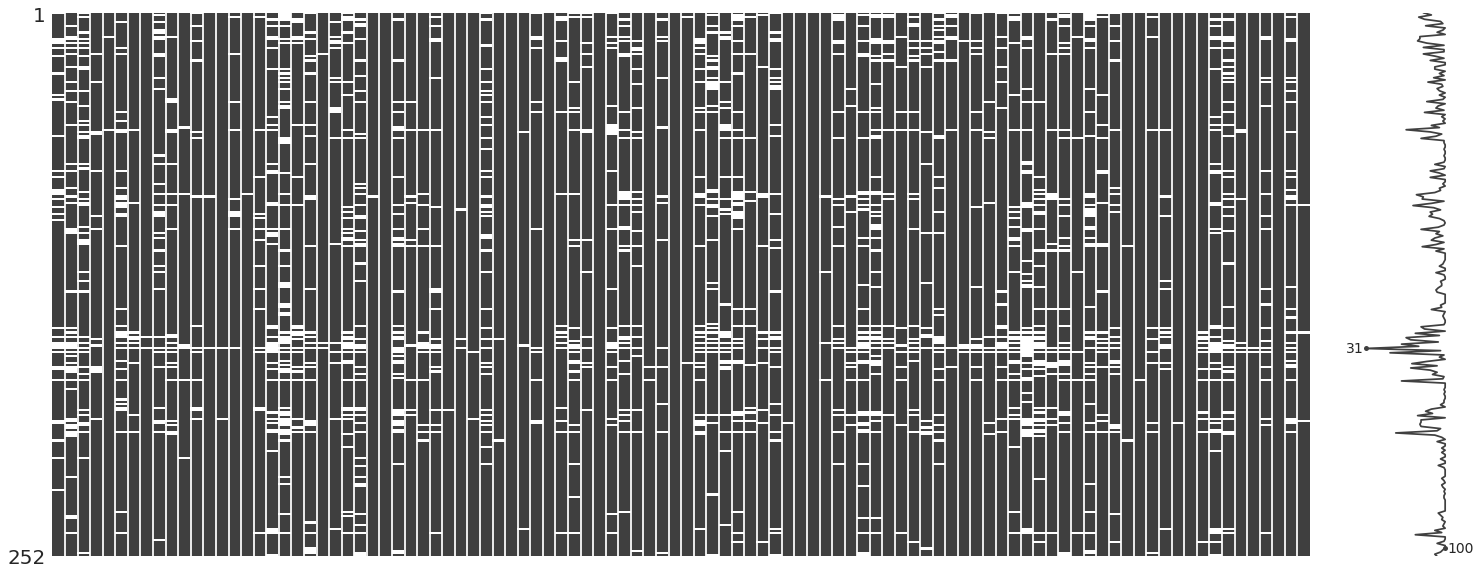

In [10]:
mno.matrix(df_idio_vola, labels=False)
plt.show()

In [11]:
print('{:.2f}% of observations missing'.format((df_idio_vola.isna()).sum().sum() / len(df_idio_vola.stack(dropna=False))*100))

6.77% of observations missing


In [12]:
df_idio_vola = src.utils.log_replace(df_idio_vola, method='min')

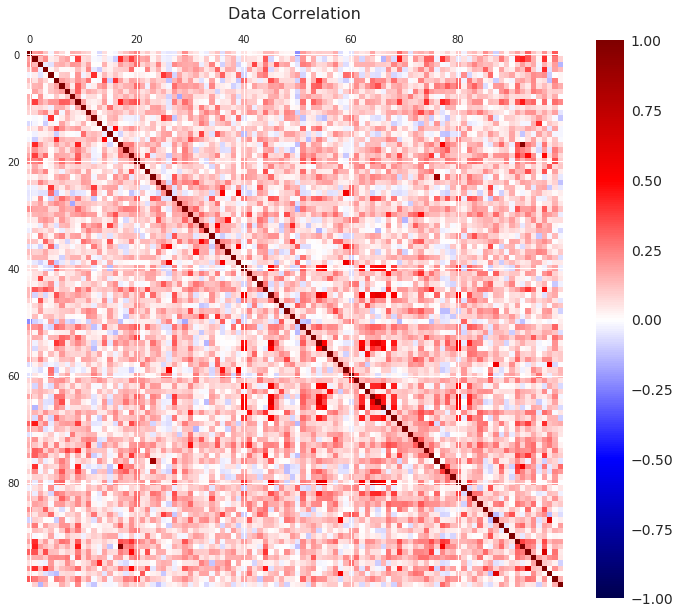

In [13]:
src.plot.corr_heatmap(df_idio_vola.corr(), 'Data Correlation')

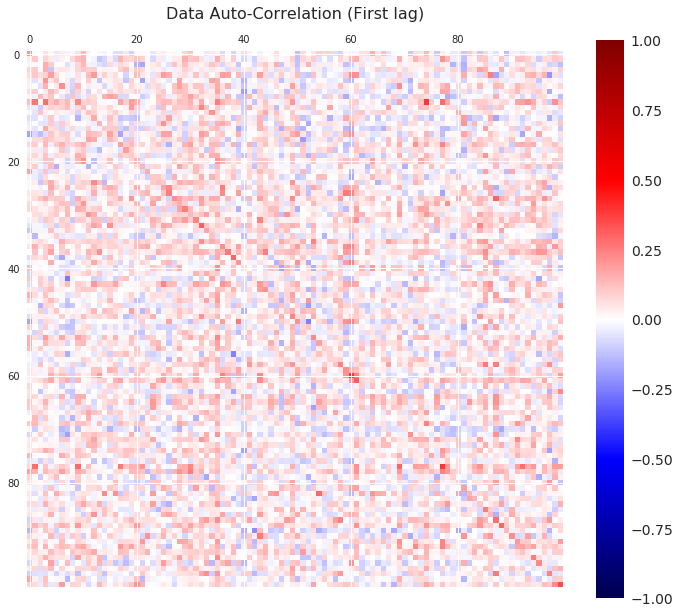

In [14]:
src.plot.corr_heatmap(src.utils.autocorrcoef(df_idio_vola, lag=1), title='Data Auto-Correlation (First lag)')

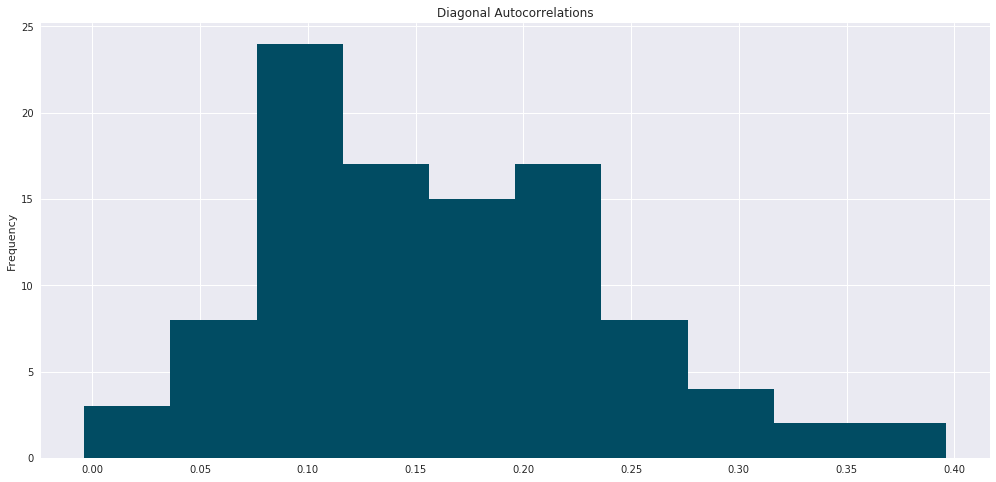

In [15]:
pd.Series(np.diag(src.utils.autocorrcoef(df_idio_vola, lag=1))).plot(kind='hist', title='Diagonal Autocorrelations', bins=10)

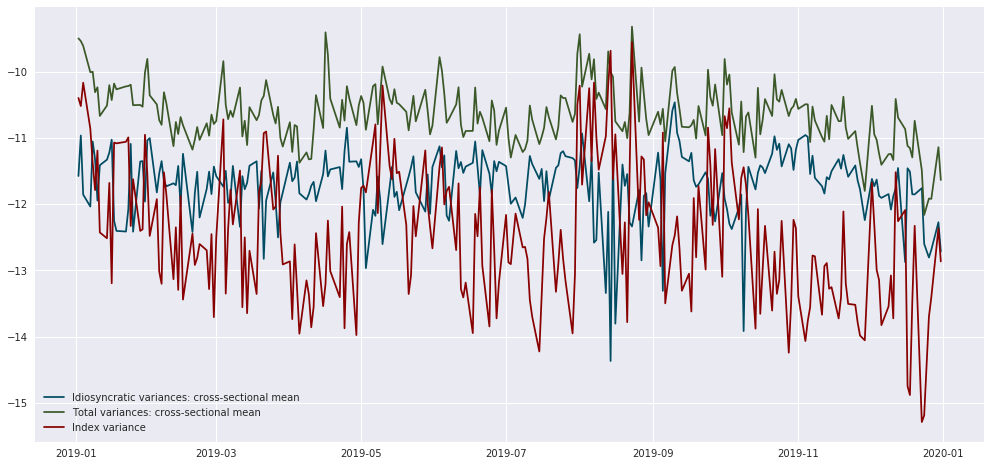

In [16]:
src.plot.vola_timeseries(df_idio_vola, total_volas=df_volas**2, index_vola=df_spy_vola**2)

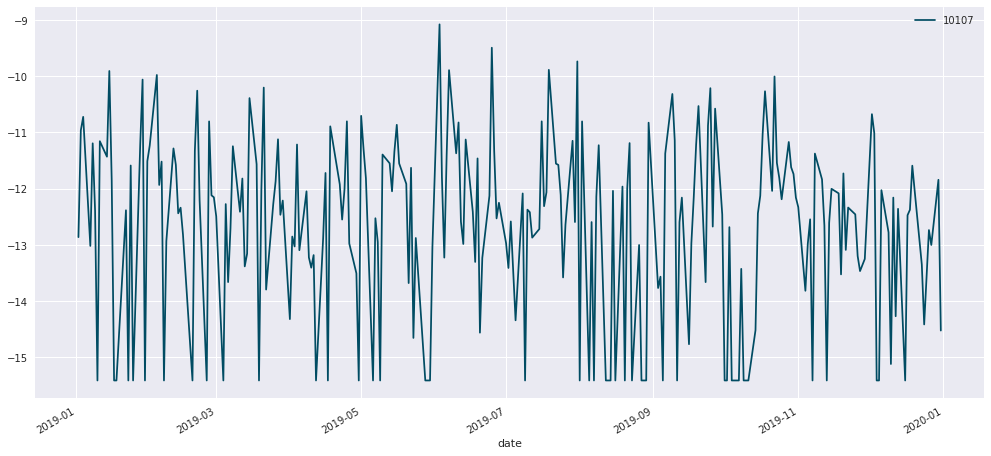

In [17]:
df_idio_vola.iloc[:,1:2].plot()
plt.show()

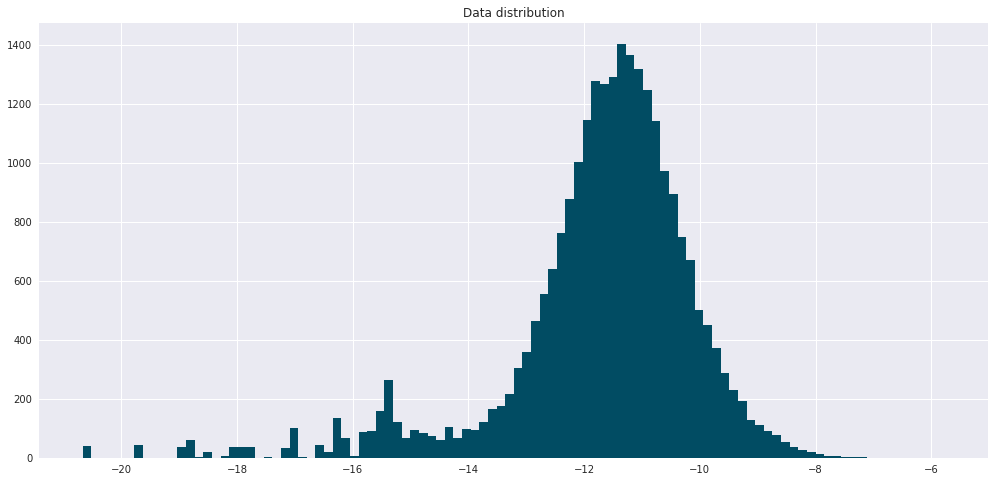

In [18]:
src.plot.histogram(df_idio_vola.stack())

### VAR estimation

$r_{i,t} = \alpha_i + \sum_{k=1}^{K} \beta_{i,k} f_{k,t} + \sum_{j=1}^{N} \gamma_{i,j} r_{j,t-1}  + u_{i,t}$

where
- $r_{i,t}$: $1 \times 1$ (asset excess returns)
- $\alpha_i$: $1 \times 1$ (intercepts/pricing errors)
- $f_{k,t}$: $1 \times 1$ (factor excess returns)
- $\beta_{i,k}$: $1 \times 1$ (factor loadings)
- $\gamma_{i,j}$: $1 \times 1$ (VAR coefficients)
- $u_{i,t}$: $1 \times 1$ (error term)

Adaptive Elastic Net with hyperparameters $\lambda, \kappa$

$(\hat{\alpha}, \hat{\beta}, \hat{\gamma})= \underset{(\alpha, \beta, \gamma)}{argmin} \Bigg[ \frac{1}{2NT}\sum_{i=1}^{N}\sum_{t=1}^{T} \Big(r_{i,t} - \big(\alpha_i + \sum_{k=1}^{K} \beta_{i,k} f_{k,t} + \sum_{j=1}^{N} \gamma_{i,j} r_{j,t-1}\big)\Big)^2 + \lambda \sum_{i=1}^{N}\sum_{j=1}^{N} w_{i,j} \big(\kappa |\gamma_{i,j}| + (1-\kappa) \frac{1}{2} \gamma_{i,j}^2\big)\Bigg]$

weights are set to $w_{i,j} =|\hat{\beta}_{i,j,OLS}|^{-1}$

In [19]:
# Regular VAR
var = src.VAR(df_idio_vola, p_lags=1)

In [20]:
# # VAR including SPY as a series
# var = src.VAR(df_volas.join(df_spy_vola), p_lags=1)

In [21]:
# # VAR with exogenous factor regressor
# var = src.VARX(df_volas, df_spy_vola, p_lags=1)

In [22]:
# # for regular data
# hyperparameter_grid = {'alpha': [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1],
#                        'lambdau': np.geomspace(1e-10, 1e-4, 15),
#                        }

In [23]:
# for logged data
var_grid = {'alpha': [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1],
            'lambdau': np.geomspace(1e-5, 1e-0, 15),
            }

In [24]:
var_cv = var.fit_elastic_net_cv(grid=var_grid, return_cv=True)

Fitting 12 folds for each of 195 candidates, totalling 2340 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 2340 out of 2340 | elapsed:  6.9min finished


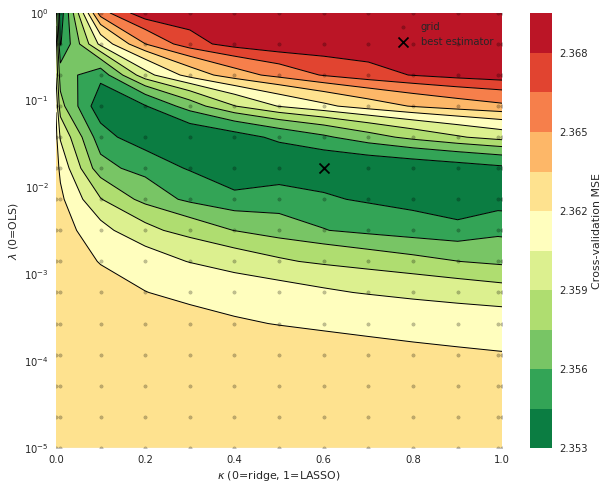

In [25]:
src.plot.net_cv_contour(var_cv, 15, logy=True)

In [26]:
gammas = var.var_1_matrix_
n_series = var.n_series
density = (gammas!=0).sum()/n_series**2*n_series
κ = var_cv.best_params_['alpha']
λ = var_cv.best_params_['lambdau']
print('VAR(1) matrix is {:.2f}% dense.'.format(density))
print('Best hyperparameters are alpha={:.2f}, lambda={:.10f}.'.format(κ, λ))
print('Average VAR spillover is {:.4f}, absolute {:.4f}'.format(gammas.mean(), abs(gammas).mean()))
try:
    print('Mean factor loading is {:.4f}, with min {:.4f}, max {:.4f}'.format(var.exog_loadings_.mean(), var.exog_loadings_.min(), var.exog_loadings_.max()))
except:
    pass

VAR(1) matrix is 35.73% dense.
Best hyperparameters are alpha=0.60, lambda=0.0163789371.
Average VAR spillover is 0.0000, absolute 0.0012


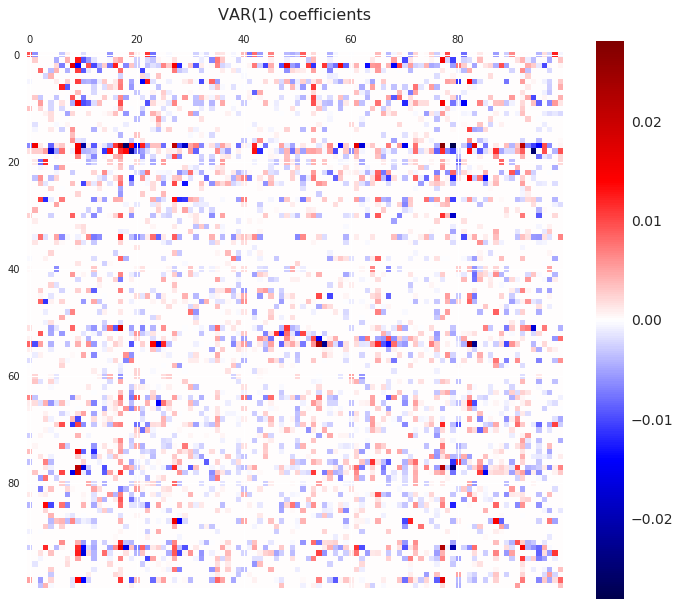

In [27]:
absmax = abs(gammas).max()
src.plot.corr_heatmap(gammas, 'VAR(1) coefficients', vmin=-absmax, vmax=absmax)

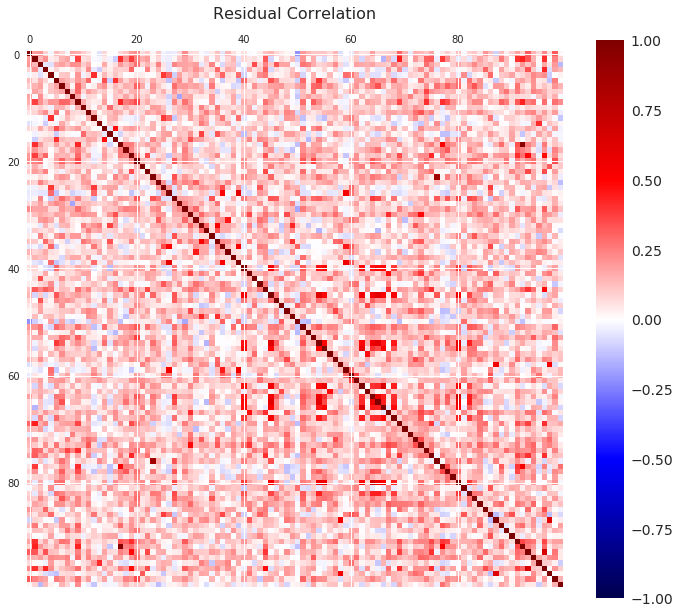

In [28]:
src.plot.corr_heatmap(pd.DataFrame(var.residuals_).corr(), 'Residual Correlation')

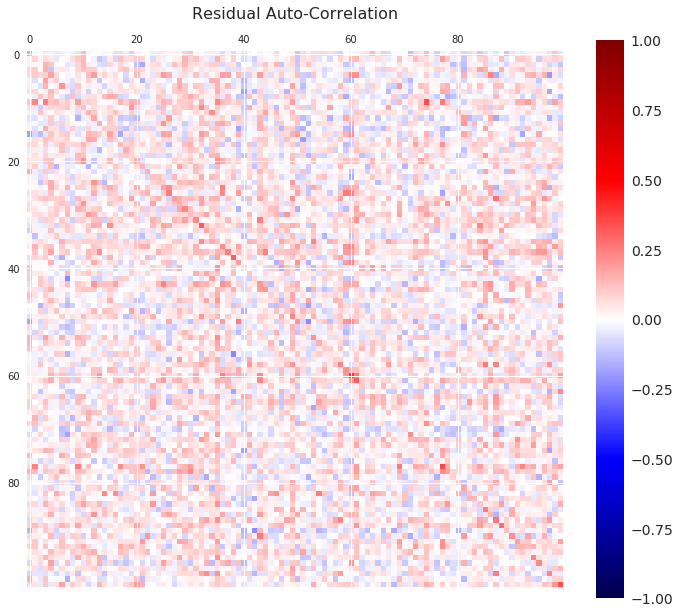

In [29]:
src.plot.corr_heatmap(src.utils.autocorrcoef(pd.DataFrame(var.residuals_), lag=1), 'Residual Auto-Correlation')

In [30]:
#src.plot.corr_heatmap(pd.DataFrame(var.exog_residuals_).corr(), 'Factor Model Residual Correlation')

### Covariance matrix estimation

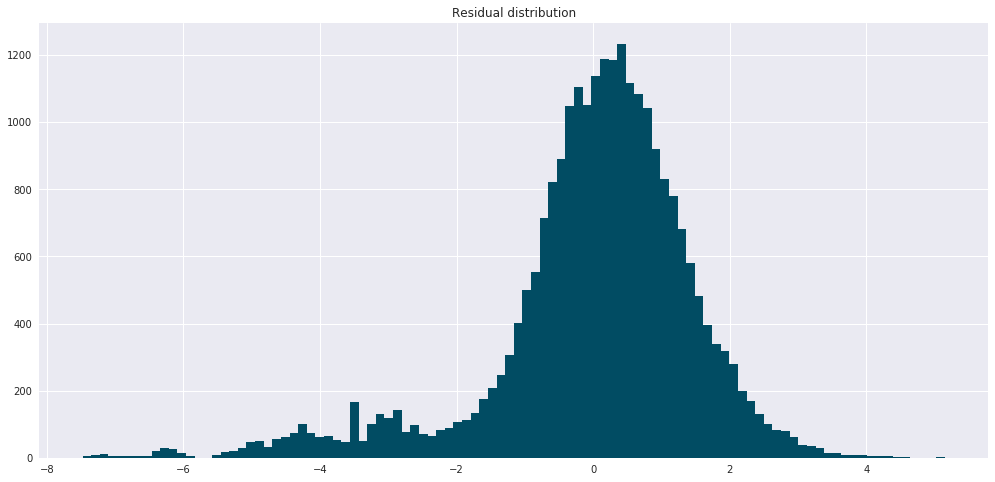

In [31]:
src.plot.histogram(var.residuals_.ravel(), title='Residual distribution')

In [32]:
ate = src.covar.AdaptiveThresholdEstimator()

In [33]:
cov_grid = {'confidence_level': np.append(np.linspace(0.5, 0.95, 10), np.array([0.9999])),
            'eta': np.linspace(0, 2, 13)}

# cov_grid = {'confidence_level': np.append(np.linspace(0.5, 0.95, 10), np.array([0.9999])),
#             'eta': np.linspace(0, 3, 13)}

In [34]:
cov_cv = GridSearchCV(ate, cov_grid, cv=12, n_jobs=-1, verbose=1).fit(var.residuals_)
covar = cov_cv.best_estimator_.covar_

Fitting 12 folds for each of 143 candidates, totalling 1716 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1716 out of 1716 | elapsed:  2.8min finished


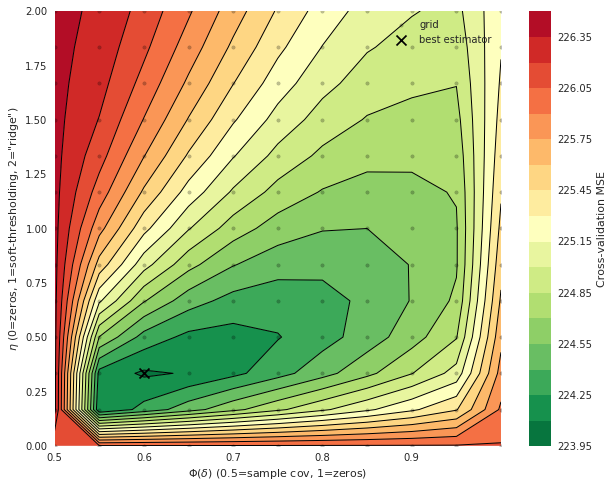

In [35]:
src.plot.cov_cv_contour(cov_cv, 15, logy=False)

In [36]:
density = (covar!=0).sum()/n_series**2*n_series
Φδ = cov_cv.best_params_['confidence_level']
η = cov_cv.best_params_['eta']
print('covariance matrix is {:.2f}% dense.'.format(density))
print('Best hyperparameters are confidence_level={:.2f}, eta={:.10f}.'.format(Φδ, η))
print('Values were shrunk by {:.2f}% on average.'.format((1-(covar/np.cov(var.residuals_, rowvar=False)).mean())*100))

covariance matrix is 79.12% dense.
Best hyperparameters are confidence_level=0.60, eta=0.3333333333.
Values were shrunk by 76.12% on average.


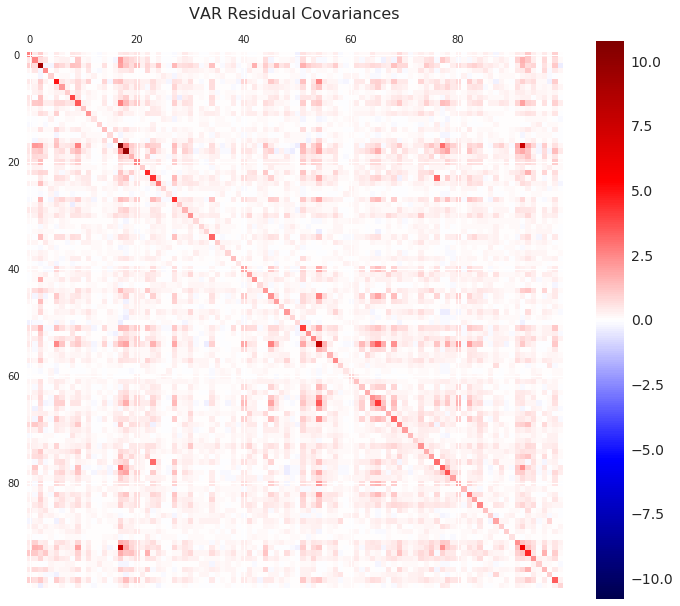

In [56]:
_ = pd.DataFrame(var.residuals_).cov()
src.plot.corr_heatmap(_, 'VAR Residual Covariances', vmin=-abs(_.values).max(), vmax=abs(_.values).max())

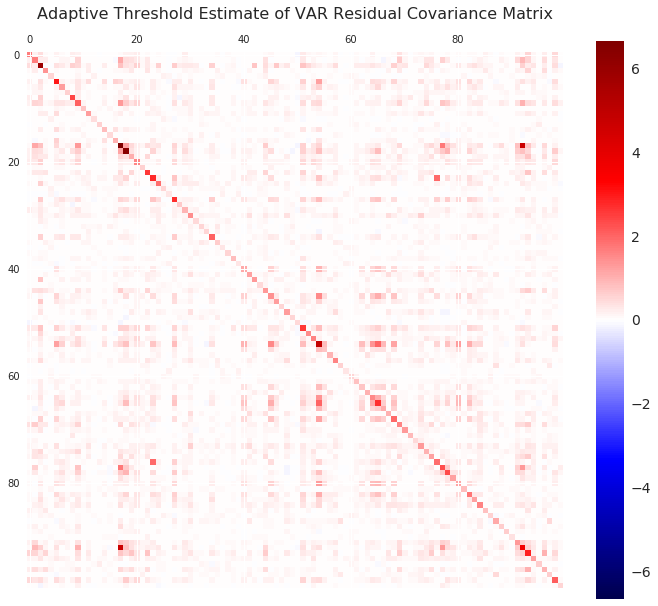

In [55]:
absmax = abs(covar).max()
src.plot.corr_heatmap(covar, 'Adaptive Threshold Estimate of VAR Residual Covariance Matrix', vmin=-absmax, vmax=absmax)

### FEVD

In [119]:
horizon = 10
fevd = src.FEVD(var.var_1_matrix_, covar)

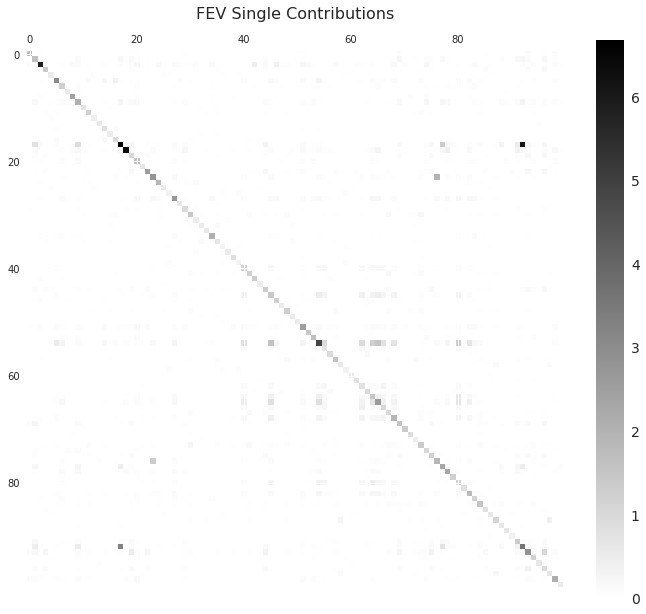

In [130]:
#absmax = abs(fevd.fev_single(horizon)).max()
src.plot.corr_heatmap(pd.DataFrame(fevd.fev_single(horizon)), 'FEV Single Contributions', vmin=0, cmap='binary', infer_vmax=True)

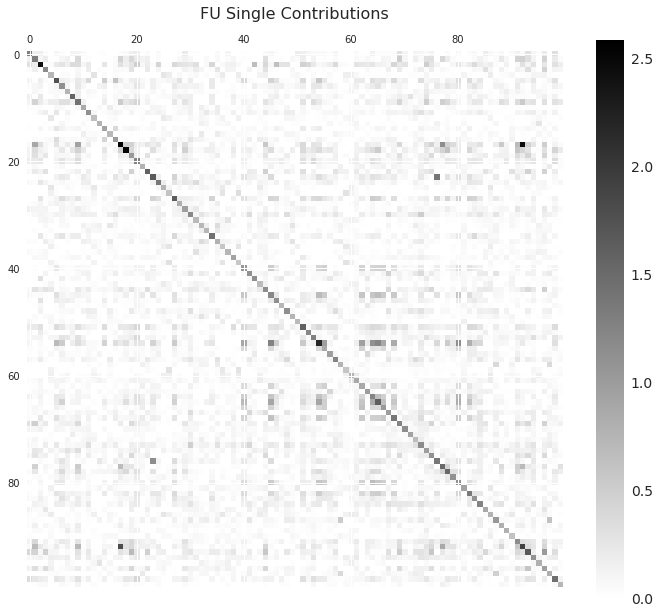

In [132]:
src.plot.corr_heatmap(pd.DataFrame(fevd.fu_single(horizon)), 'FU Single Contributions', vmin=0, infer_vmax=True, cmap='binary')

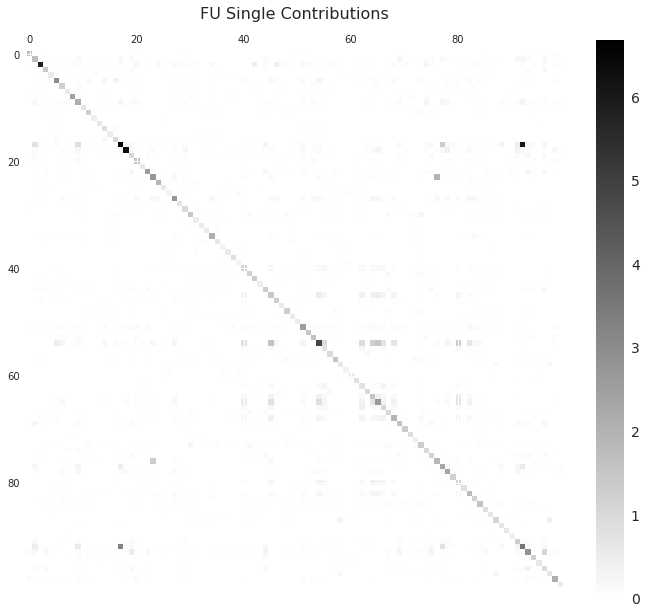

In [134]:
src.plot.corr_heatmap(pd.DataFrame(fevd.fev_single(horizon)), 'FU Single Contributions', cmap='binary', infer_vmax=True)

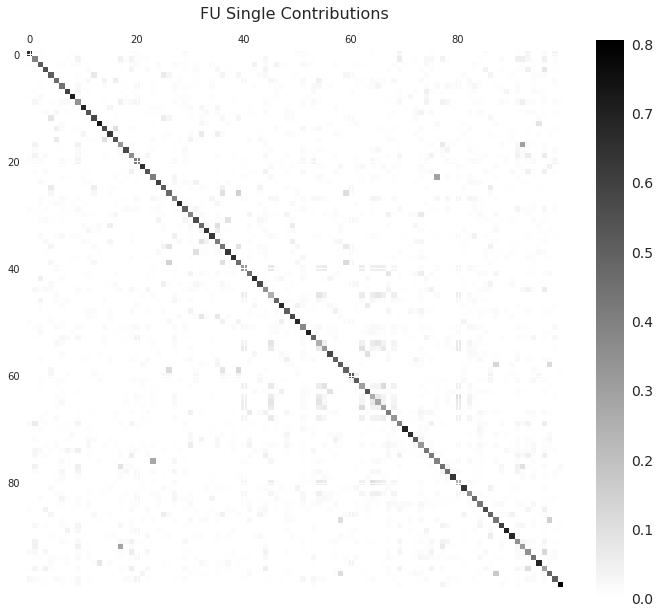

In [136]:
src.plot.corr_heatmap(pd.DataFrame(fevd.decompose_fev(horizon, normalise=True)), 'FU Single Contributions', cmap='binary', infer_vmax=True)

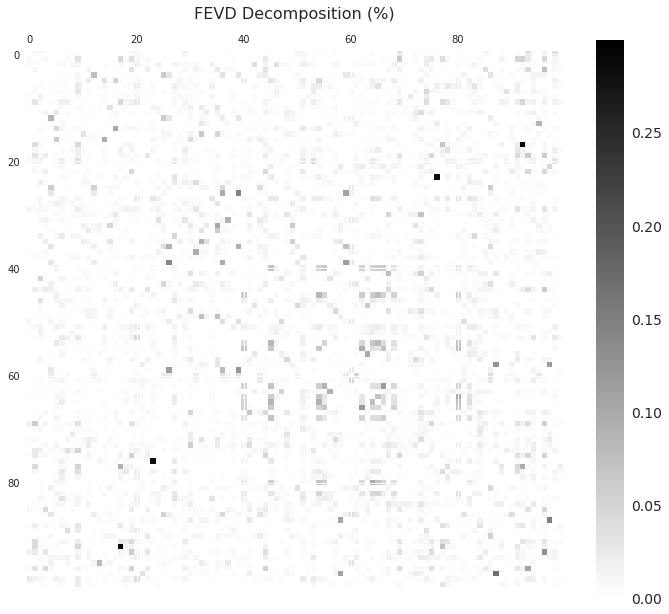

In [109]:
src.plot.corr_heatmap(pd.DataFrame(fevd.decompose_pct(horizon=horizon))-np.diag(np.diag(fevd.decompose_pct(horizon=horizon))), 'FEVD Decomposition (%)', vmin=0, vmax=None, cmap='binary')

### Network structure

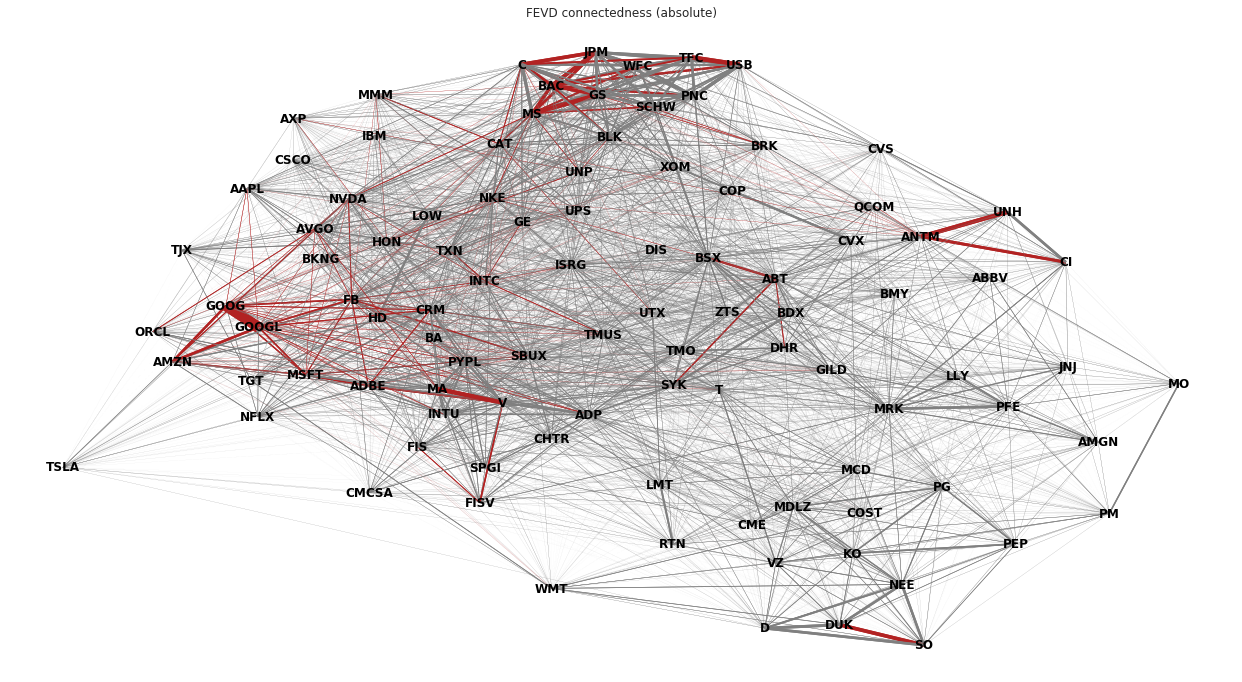

In [137]:
graph = fevd.to_fev_graph(horizon, normalise=False)
column_to_ticker = dict(pd.read_csv('../data/processed/annual/{}/tickers.csv'.format(year))['permno_to_ticker'])
src.plot.network_graph(graph, column_to_ticker, red_percent=5, title='FEVD connectedness (absolute)', linewidth=0.25)

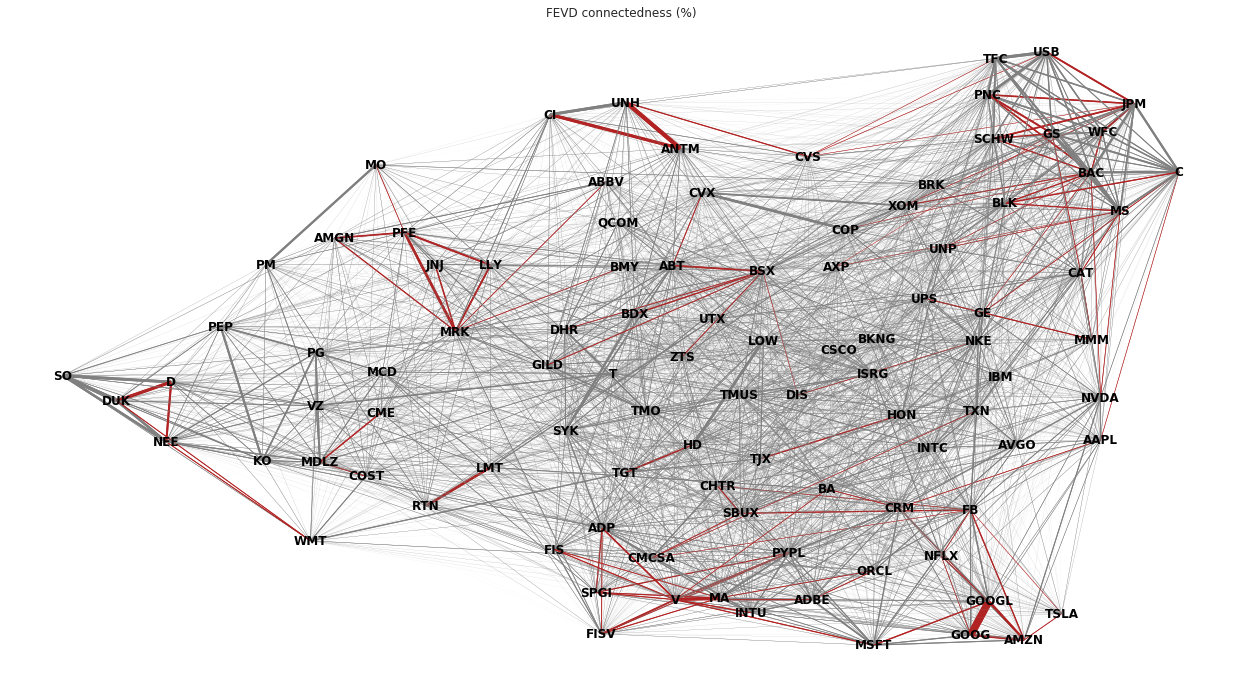

In [146]:
graph = fevd.to_fev_graph(horizon, normalise=True)
column_to_ticker = dict(pd.read_csv('../data/processed/annual/{}/tickers.csv'.format(year))['permno_to_ticker'])
src.plot.network_graph(graph, column_to_ticker, red_percent=2, title='FEVD connectedness (%)', linewidth=0.25)

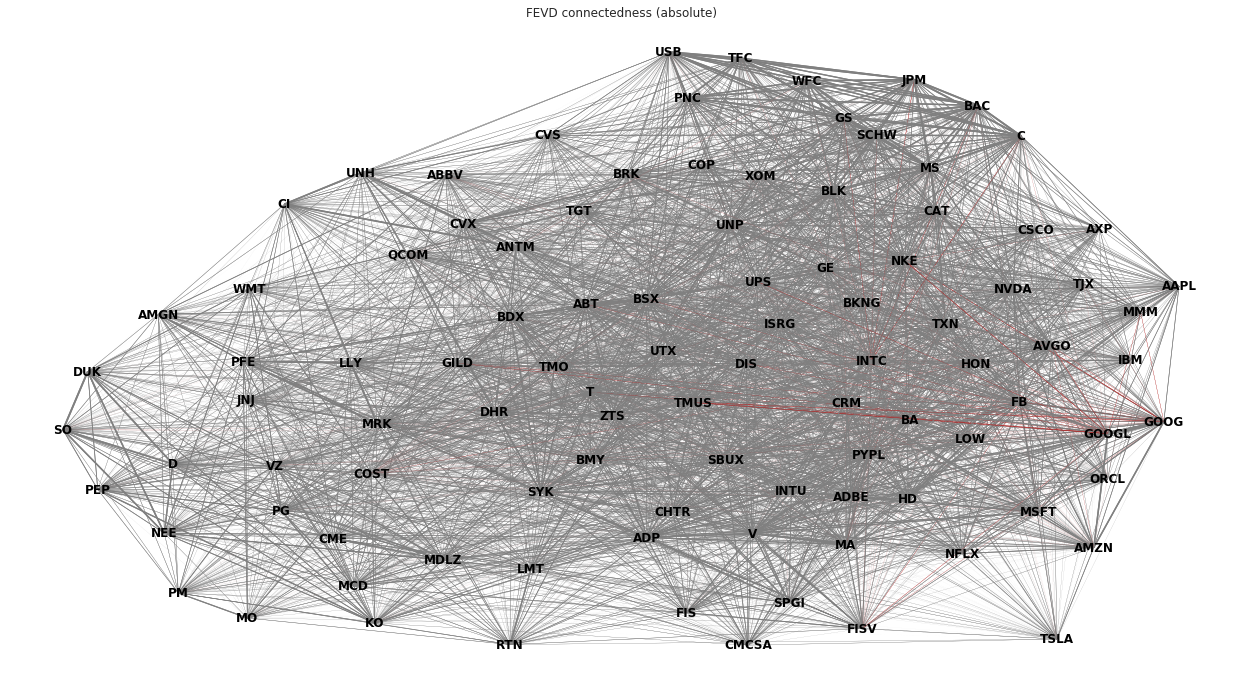

In [138]:
graph = fevd.to_fu_graph(horizon, normalise=False)
column_to_ticker = dict(pd.read_csv('../data/processed/annual/{}/tickers.csv'.format(year))['permno_to_ticker'])
src.plot.network_graph(graph, column_to_ticker, red_percent=5, title='FEVD connectedness (absolute)', linewidth=0.25)

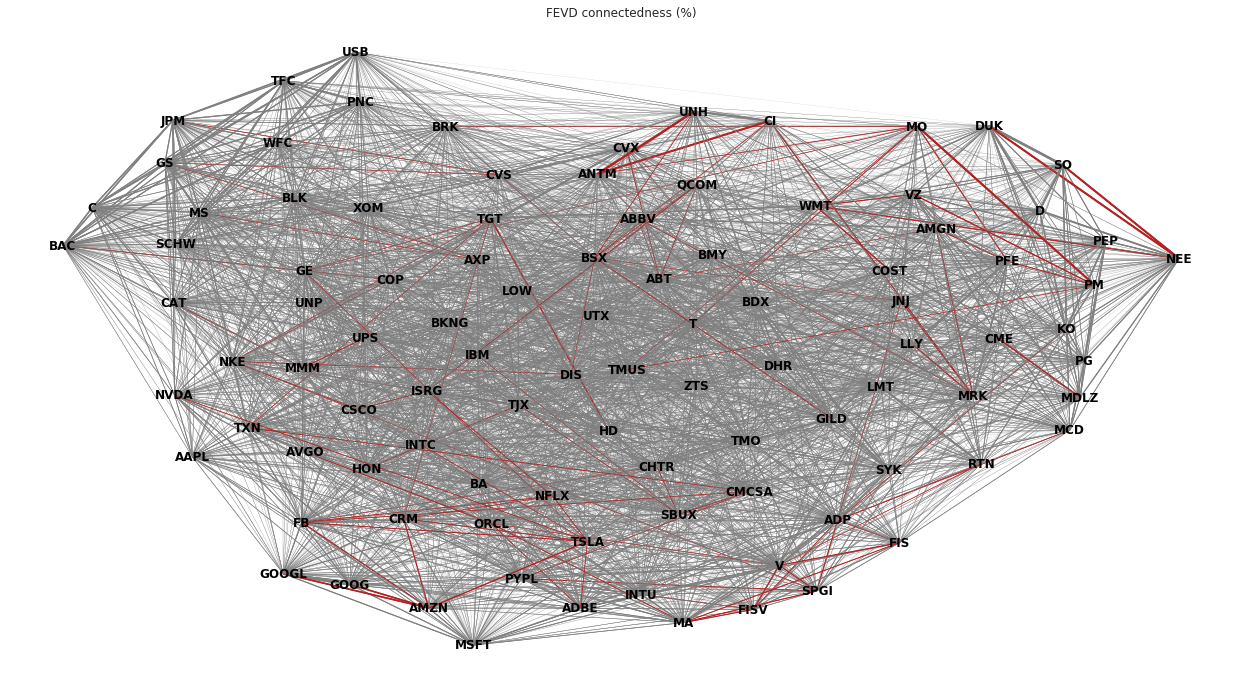

In [140]:
graph = fevd.to_fu_graph(horizon, normalise=True)
column_to_ticker = dict(pd.read_csv('../data/processed/annual/{}/tickers.csv'.format(year))['permno_to_ticker'])
src.plot.network_graph(graph, column_to_ticker, red_percent=2, title='FEVD connectedness (%)', linewidth=0.25)

In [101]:
src.utils.lookup_ticker('CO', year).iloc[-1, :]

permno                       93123
comnam      GLOBAL CORD BLOOD CORP
namedt         2019-09-17 00:00:00
nameendt       2019-12-31 00:00:00
exchcd                           1
Name: CO, dtype: object

In [108]:
def make_ticker_table(): #note 2019 BRK ticker is duplicated
    ticker_table = kf.FinancialSeries(dtype='object', name='Company Name', index=pd.Index(data=[], name='Ticker'))
    for ticker in tickers['permno_to_ticker'].values:
        data = src.utils.lookup_ticker(ticker, year)
        if isinstance(data, pd.DataFrame):
            data = data.iloc[-1, :]
        ticker_table[ticker] = data['comnam'].replace('&', '\&').title()
    ticker_table = ticker_table.to_frame().sort_index()
    return ticker_table

In [109]:
ticker_table = make_ticker_table()
ticker_table.export_to_latex(filename='tickers.tex', path='../reports/tables/')

In [323]:
pd.read_pickle('../data/raw/crsp_1999.pkl')

ticker        mcap      vola    retadj
date       permno                                       
1999-01-04 10001    EWST   22999.500  0.000000 -0.012987
           10002    SABC  119799.500  0.000000  0.016393
           10009    IROQ   51513.750  0.009153  0.017857
           10012    DPAC   16185.625  0.026548  0.000000
           10016    SCTT  295538.750  0.005951 -0.017013
...                  ...         ...       ...       ...
1999-12-31 92807    UBAN  156322.000  0.010869  0.000000
           92866     VTX  104304.000  0.003181  0.009231
           92874    VIDE   16961.750  0.007561  0.030303
           93105    WBPR  435750.000  0.007833  0.024691
           93316    ZING   39680.750  0.017647  0.009804

[1708555 rows x 4 columns]

## TRIALS: Correlation Elastic Net

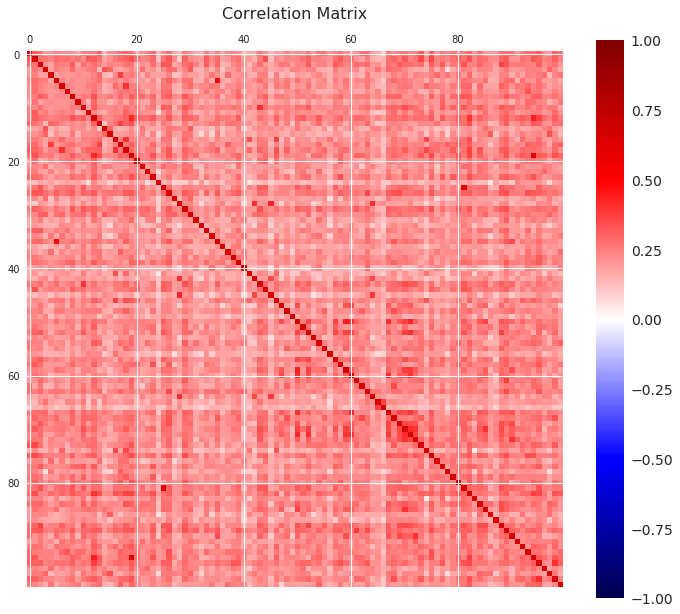

In [247]:
from sklearn.linear_model import LinearRegression
from src.net import ElasticNet
_ = src.covar.CorrelationNet()
_.fit_elastic_net(df_volas, return_model=False, lambdau=5e-5, alpha=0)
#_.fit_OLS(df_volas, return_model=False)
src.plot.corr_heatmap(_.coef_.reshape(100,-1))

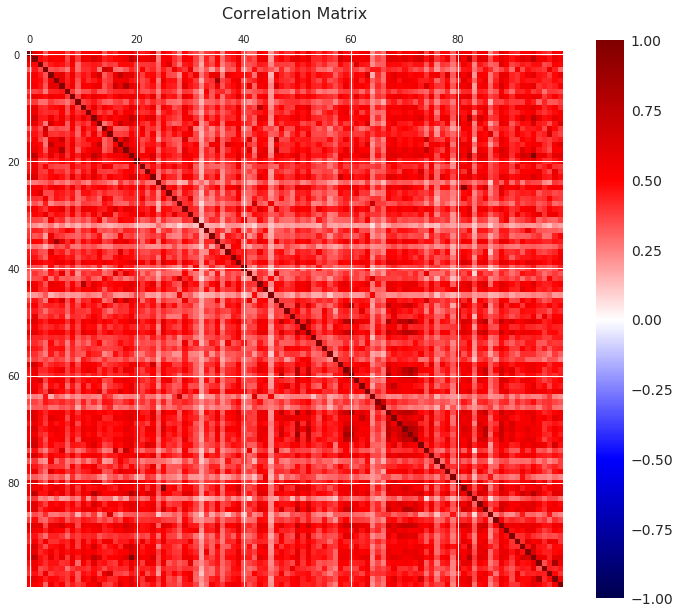

In [248]:
src.plot.corr_heatmap(df_volas.corr())

In [204]:
A = fevd.decompose_pct(10)

In [205]:
B = (A + A.T)/2

In [206]:
src.utils.matrix_asymmetry(A)

0.05755638301049168

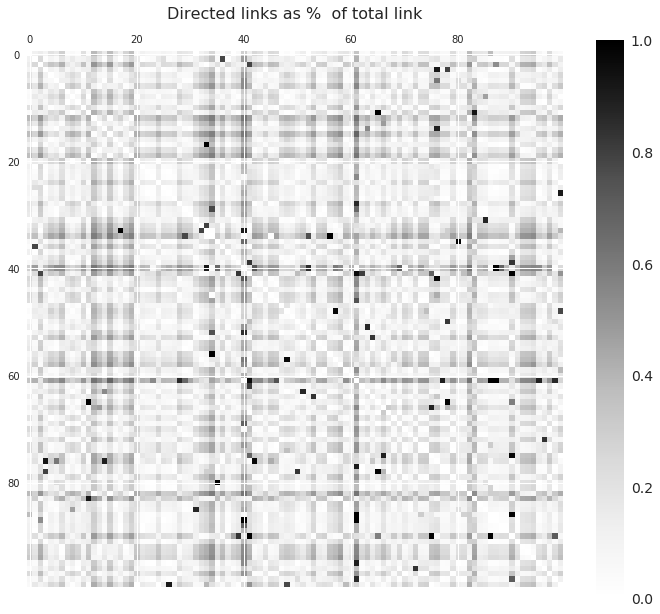

In [213]:
src.plot.corr_heatmap(abs(A/B-1), vmin=0, vmax=1, title='Directed links as %  of total link', cmap='Greys')

In [288]:
from sklearn.decomposition import FactorAnalysis
factors = pd.DataFrame(FactorAnalysis(n_components=1).fit_transform(df_est))
favar = src.FAVAR(df_est, factors, p_lags=1)

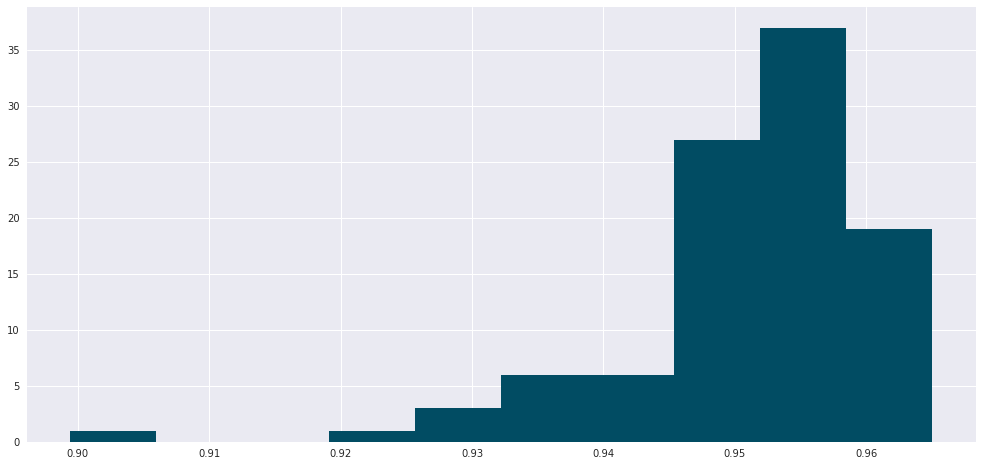

In [29]:
pd.Series(fevd.in_connectedness(horizon=horizon).ravel()).hist()
plt.show()

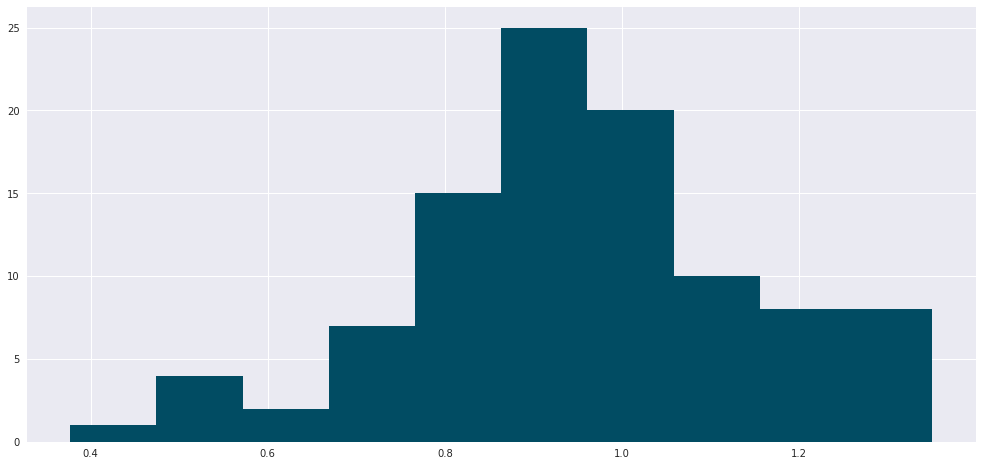

In [30]:
pd.Series(fevd.out_connectedness(horizon=horizon).ravel()).hist()
plt.show()

In [239]:
fevd_10 = fevd.summarize(10)

In [221]:
create_results_data(df_est, df_ana, favar, cv, fevd, horizon).corr().round(4)

mean_est_ret  mean_ana_ret    beta   alpha  \
mean_est_ret                 1.0000        0.7661  0.7386  0.9828   
mean_ana_ret                 0.7661        1.0000  0.3735  0.7396   
beta                         0.7386        0.3735  1.0000  0.7332   
alpha                        0.9828        0.7396  0.7332  1.0000   
in_connectedness             0.5047        0.2095  0.7618  0.4952   
out_connectedness            0.4252        0.1602  0.6978  0.4167   
fev_others                   0.7904        0.4733  0.7671  0.7896   
fev_all                      0.8787        0.6671  0.5764  0.8514   
average_connectedness       -0.0000        0.0000  0.0000 -0.0000   

                       in_connectedness  out_connectedness  fev_others  \
mean_est_ret                     0.5047             0.4252      0.7904   
mean_ana_ret                     0.2095             0.1602      0.4733   
beta                             0.7618             0.6978      0.7671   
alpha                            0.4952             0.4167      0.7896   
in_connectedness                 1.0000             0.9618      0.7304   
out_connectedness                0.9618             1.0000      0.7281   
fev_others                       0.7304             0.7281      1.0000   
fev_all                          0.3223             0.2682      0.7775   
average_connectedness           -0.0000             0.0000      0.0000   

                       fev_all  average_connectedness  
mean_est_ret            0.8787                   -0.0  
mean_ana_ret            0.6671                    0.0  
beta                    0.5764                    0.0  
alpha                   0.8514                   -0.0  
in_connectedness        0.3223                   -0.0  
out_connectedness       0.2682                    0.0  
fev_others              0.7775                    0.0  
fev_all                 1.0000                    0.0  
average_connectedness   0.0000                    1.0

## Analysis

In [71]:
def create_results_data(df_est, df_ana, favar, cv, fevd, horizon): #graph
    '''Creates a dataframe containing estimation results.'''
    df = pd.DataFrame(index=favar.var_data.columns)
    df['mean_est_ret'] = df_est.mean()*252
    df['mean_ana_ret'] = df_ana.mean()*252
    df['beta'] = favar.factor_loadings_
    df['alpha'] = favar.intercepts_
    df['in_connectedness'] = fevd.in_connectedness(horizon=horizon)
    df['out_connectedness'] = fevd.out_connectedness(horizon=horizon)
    df['fev_others'] = fevd.fev_others(horizon=horizon)
    df['fev_all'] = fevd.fev_all(horizon=horizon)
    df['average_connectedness'] = fevd.average_connectedness(horizon=horizon) 
    #df['eigenvector_centrality'] = np.linalg.eig(favar.residual_cov_('LW'))[1][:,0]
    #df['network_centraility'] = nx.eigenvector_centrality(graph)
    
    return df

In [581]:
def estimate_single_year(year, selected_factors, grid, horizon):
    
    # load data
    df_est, df_ana, df_factors_est, df_factors_ana = src.loader.load_year_all(year)
    fac_est, fac_ana = src.loader.select_factor_data(df_factors_est, df_factors_ana, selected_factors=selected_factors)
    
    # favar
    favar = src.FAVAR(df_est, fac_est, p_lags=1)
    cv = favar.fit_elastic_net_cv(grid=hyperparameter_grid, return_cv=True)
    
    # fevd
    fevd = src.FEVD(favar.var_1_matrix_, favar.residual_cov_('LW'))
    
    # save results
    df_year = create_results_data(df_est, df_ana, favar, cv, fevd, horizon)
    
    return df_year
    

In [580]:
def estimate_single_year_vola(year, selected_factors, grid, horizon):
    
    # load data
    df_est, df_ana, df_factors_est, df_factors_ana = src.loader.load_year_all_vola(year)
    fac_est, fac_ana = src.loader.select_factor_data(df_factors_est, df_factors_ana, selected_factors=selected_factors)
    
    # favar
    favar = src.FAVAR(df_est, fac_est, p_lags=1)
    cv = favar.fit_elastic_net_cv(grid=hyperparameter_grid, return_cv=True)
    
    # fevd
    fevd = src.FEVD(favar.var_1_matrix_, favar.residual_cov_('LW'))
    
    # save results
    df_year = create_results_data(df_est, df_ana, favar, cv, fevd, horizon)
    
    return df_year
    

In [92]:
df_results = pd.DataFrame([])
for year in range(2000, 2019):
    df_year = estimate_single_year(year=year, selected_factors=['mktrf'], grid=hyperparameter_grid, horizon=10)
    df_year.index = pd.MultiIndex.from_product([[year], df_year.index])
    
    df_results = df_results.append(df_year)
    df_results.to_csv('../data/interim/df_results.csv')
    print('finished year {}'.format(year))

Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  6.5min finished


finished year 2000
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.5min finished


finished year 2001
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.2min finished


finished year 2002
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  6.6min finished


finished year 2003
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.3min finished


finished year 2004
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  4.7min finished


finished year 2005
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  4.8min finished


finished year 2006
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.5min finished


finished year 2007
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  6.1min finished


finished year 2008
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.8min finished


finished year 2009
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  8.1min finished


finished year 2010
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.2min finished


finished year 2011
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  4.7min finished


finished year 2012
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.0min finished


finished year 2013
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.2min finished


finished year 2014
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.3min finished


finished year 2015
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  7.1min finished


finished year 2016
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  4.7min finished


finished year 2017
Fitting 10 folds for each of 195 candidates, totalling 1950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1950 out of 1950 | elapsed:  5.8min finished


finished year 2018


In [148]:
kf.FinancialDataFrame(df_results) \
    .fit_linear_regression('mean_est_ret', ['beta', 'in_connectedness', 'fev_others']) \
    .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mean_est_ret   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     13.54
Date:                Tue, 29 Sep 2020   Prob (F-statistic):           9.62e-09
Time:                        13:22:12   Log-Likelihood:                -234.52
No. Observations:                1900   AIC:                             477.0
Df Residuals:                    1896   BIC:                             499.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1507      0.027      5.631      0.000       0.098       0.203
beta                 0.0783      0.016      4.831      0.000       0.047       0.110
in_connectedness    -0.1803      0.050     -3.627      0.000      -0.278      -0.083
fev_others         -11.7620     13.845     -0.850      0.396     -38.915      15.391
==============================================================================
Omnibus:                      155.409   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              887.275
Skew:                           0.070   Prob(JB):                    2.14e-193
Kurtosis:                       6.345   Cond. No.                     3.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
kf.FinancialDataFrame(df_results) \
    .fit_linear_regression('mean_ana_ret', ['beta', 'alpha', 'in_connectedness', 'fev_others']) \
    .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           mean_ana_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3150
Date:                Mon, 28 Sep 2020   Prob (F-statistic):              0.868
Time:                        23:41:02   Log-Likelihood:                -1685.1
No. Observations:                1896   AIC:                             3380.
Df Residuals:                    1891   BIC:                             3408.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1008      0.058      1.740      0.082      -0.013       0.214
beta                -0.0221      0.035     -0.631      0.528      -0.091       0.047
alpha               -9.4724     14.639     -0.647      0.518     -38.182      19.237
in_connectedness     0.0411      0.107      0.384      0.701      -0.169       0.251
fev_others          16.4674     30.917      0.533      0.594     -44.168      77.103
==============================================================================
Omnibus:                     4666.037   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         70336179.752
Skew:                          25.009   Prob(JB):                         0.00
Kurtosis:                     945.247   Cond. No.                     3.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
kf.FinancialDataFrame(df_results) \
    .fit_linear_regression('beta', ['alpha', 'in_connectedness', 'fev_others']) \
    .summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   beta   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     87.36
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           6.04e-53
Time:                        23:42:30   Log-Likelihood:                -890.04
No. Observations:                1900   AIC:                             1788.
Df Residuals:                    1896   BIC:                             1810.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9400      0.031     30.108      0.000       0.879       1.001
alpha              -32.0714      9.568     -3.352      0.001     -50.837     -13.306
in_connectedness    -0.0735      0.070     -1.047      0.295      -0.211       0.064
fev_others         265.1943     18.884     14.043      0.000     228.158     302.231
==============================================================================
Omnibus:                       14.657   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.546
Skew:                          -0.017   Prob(JB):                     2.10e-05
Kurtosis:                       3.521   Cond. No.                     2.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""